# Logistic regression between PTB and LST

Project: The Moderating Effects of Green Space in the Ambient Temperature and Preterm Birth Relationship: A Geographic Information Science Study in Detroit, 2018-2021

Input
* Pre-term birth (PTB)
* Land-surface temperature (LST, monthly, 1 km)


In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
from pathlib import Path

import matplotlib.pyplot as plt

import geopandas as gpd


In [6]:
# define input
wd = rf"D:\GEO874_FA23"
f_pts = rf"{wd}\data_output\PTB_LST.shp"

# Read points from shapefile
pts = gpd.read_file(f_pts)
pts.head()

,COMID,BCERT,BYEAR,BMONTH,IPLEURAL,PRETERM,VPRETERM,EPRETERM,GESTCALC,GESTEST,...,LST_month1,LST_month2,LST_month3,LST_month4,LST_month5,LST_month6,LST_month7,LST_month8,LST_month9,geometry
0,7300_2021,7300,2021,1,1,1,1,1,22,22,...,33.06,25.03,16.78,12.25,4.21,NaN,NaN,NaN,NaN,POINT (-83.16355 42.44379)
1,10252_2020,10252,2020,2,1,1,1,1,22,22,...,27.69,19.17,-3.35,2.31,-2.57,NaN,NaN,NaN,NaN,POINT (-83.00589 42.43755)
2,10550_2019,10550,2019,2,1,1,1,1,22,22,...,27.42,19.00,7.26,1.67,1.17,NaN,NaN,NaN,NaN,POINT (-82.92250 42.42076)
3,18054_2019,18054,2019,3,1,1,1,1,22,22,...,17.34,5.06,3.13,-5.04,0.38,NaN,NaN,NaN,NaN,POINT (-82.93746 42.36216)
4,18414_2019,18414,2019,3,1,1,1,1,22,22,...,18.84,0.79,4.01,-4.08,0.85,NaN,NaN,NaN,NaN,POINT (-82.96278 42.39510)


## Read pts data

In [7]:
print(pts.columns)

Index(['COMID', 'BCERT', 'BYEAR', 'BMONTH', 'IPLEURAL', 'PRETERM', 'VPRETERM',
       'EPRETERM', 'GESTCALC', 'GESTEST', 'IGRAMS', 'ISEX', 'MAGE', 'MRACE',
       'BLACK', 'BLACKWHITE', 'MHISP', 'MEDUC', 'HIGHSCHOOL', 'MARITAL',
       'MARRIED', 'KESSNERIND', 'SPAYMENT', 'MEDICAID', 'MSMOKE', 'ALCOHOL',
       'MDIABCHRON', 'MDIABGEST', 'MHTNCHRON', 'MHTNGEST', 'MHTNECLAMP',
       'ECLAMPSIA', 'PPRETERMBI', 'VAGBLDG', 'COMPPREGRU', 'CSECNEEDED', 'BMI',
       'BCITY', 'BZIPCODE', 'LONGITUDE', 'LATITUDE', 'DISPLAYX', 'DISPLAYY',
       'month1', 'month2', 'month3', 'month4', 'month5', 'month6', 'month7',
       'month8', 'month9', 'LST_month1', 'LST_month2', 'LST_month3',
       'LST_month4', 'LST_month5', 'LST_month6', 'LST_month7', 'LST_month8',
       'LST_month9', 'geometry'],
      dtype='object')


In [14]:
columns_LST = [f'LST_month{i}' for i in range(1, 10)]
df_X = pts[columns_LST]
df_y = pts['PRETERM']


## Exploratory data analysis

Be careful with the missing data!

In [33]:
# check nan vlaues in each column
print(df_X.isnull().sum())

# how many rows have nan values
print(df_X.isnull().sum(axis=1).sum())

# how many left if we drop rows with nan values
print(df_X.dropna().shape)

# make a new dataframe with no nan values
# df_X_no_nan = df_X.dropna()
# df_y_no_nan = df_y[df_X_no_nan.index]
# NOTE, PTB will has nan vlaues, so cannot drop rows with nan values


LST_month1      570
LST_month2      532
LST_month3      562
LST_month4      551
LST_month5      563
LST_month6      763
LST_month7      986
LST_month8     1707
LST_month9    10252
dtype: int64
16486
(10759, 9)


Should we fill by mean?

In [34]:
# NOTE, then, consider to fill nan values with mean values
X_mean = df_X.mean()
print(X_mean)

df_X_filled = df_X.fillna(df_X.mean())

# print an example to see the difference
s0 = df_X.iloc[0]
s0_filled = df_X_filled.iloc[0]
df_ = pd.DataFrame({'before': s0, 'after': s0_filled})
print(df_)

LST_month1    19.741376
LST_month2    18.965566
LST_month3    18.271706
LST_month4    18.002306
LST_month5    17.942796
LST_month6    18.010411
LST_month7    18.329030
LST_month8    18.838114
LST_month9    19.222599
dtype: float64
            before      after
LST_month1   33.06  33.060000
LST_month2   25.03  25.030000
LST_month3   16.78  16.780000
LST_month4   12.25  12.250000
LST_month5    4.21   4.210000
LST_month6     NaN  18.010411
LST_month7     NaN  18.329030
LST_month8     NaN  18.838114
LST_month9     NaN  19.222599


NOTE, I don't think this is correct. Perhaps two steps
1) For NAN due to LST missing, fill by mean/NN
2) For NAN due to short gestation, fill by padding with 0

But for now, let's just fill nan by 0.

In [35]:
# fill nan values with 0
df_X_filled = df_X.fillna(0)
X = df_X_filled.values
y = df_y.values

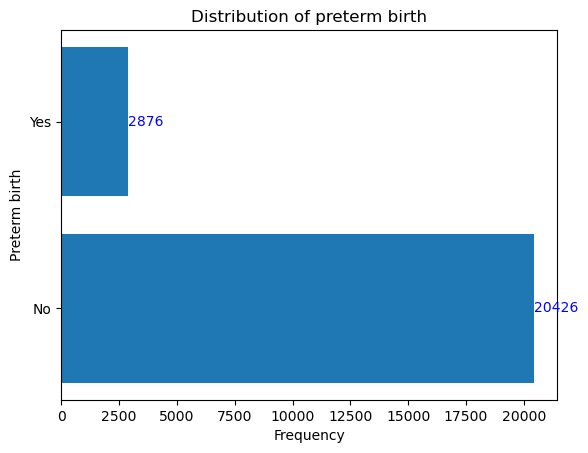

In [36]:
# Plot the distribution of the target variable
# horizontal bar plot
plt.figure()
plt.barh(['No', 'Yes'], [np.sum(y == 0), np.sum(y == 1)])
# label the bars
for i, v in enumerate([np.sum(y == 0), np.sum(y == 1)]):
    plt.text(v, i, str(v), color='blue', va='center')
    
plt.xlabel('Frequency')
plt.ylabel('Preterm birth')
plt.title('Distribution of preterm birth')
plt.show()


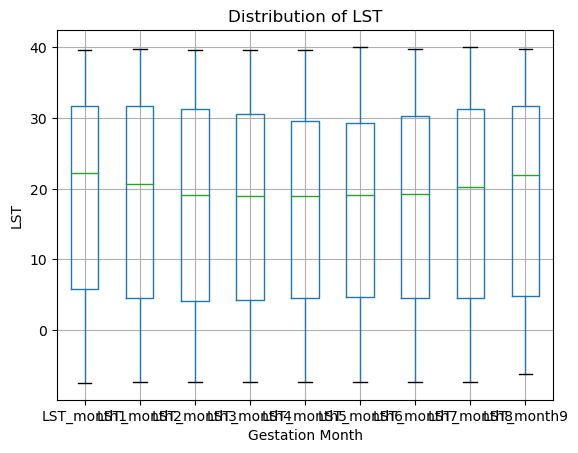

In [37]:
# Plot the distribution of the input variable
# box plot
plt.figure()
df_X.boxplot()
plt.xlabel('Gestation Month')
plt.ylabel('LST')
plt.title('Distribution of LST')
plt.show()


<Figure size 640x480 with 0 Axes>

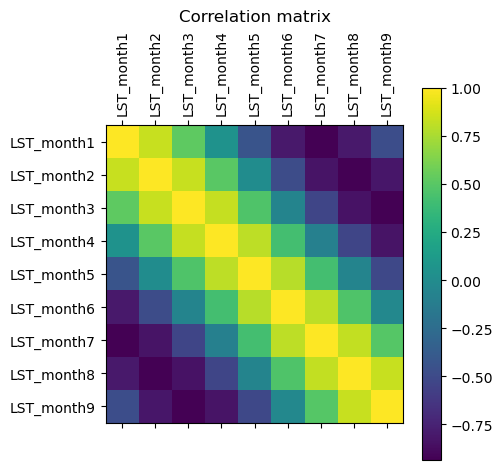

In [38]:
# check colinearity
# correlation matrix
corr = df_X.corr()
plt.figure()
plt.matshow(corr)
plt.xticks(range(len(columns_LST)), columns_LST, rotation=90)
plt.yticks(range(len(columns_LST)), columns_LST)
plt.colorbar()
plt.title('Correlation matrix')
plt.show()


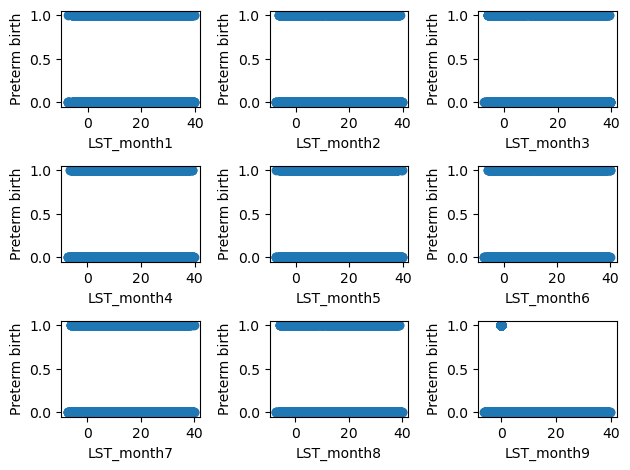

In [39]:
# check the relationship between the input and target variable
# scatter plot
plt.figure()
for i in range(len(columns_LST)):
    plt.subplot(3, 3, i+1)
    plt.scatter(X[:, i], y)
    plt.xlabel(columns_LST[i])
    plt.ylabel('Preterm birth')
plt.tight_layout()
plt.show()


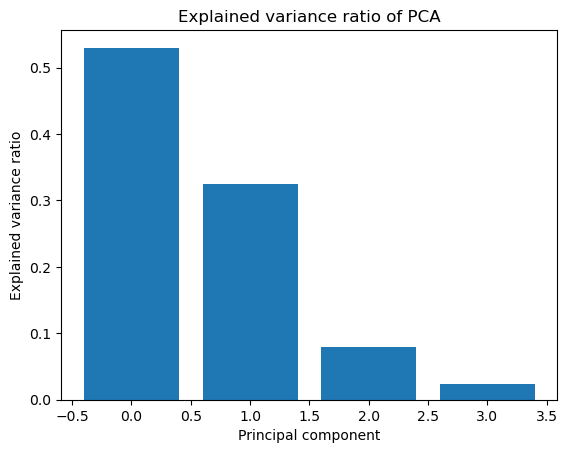

<Figure size 640x480 with 0 Axes>

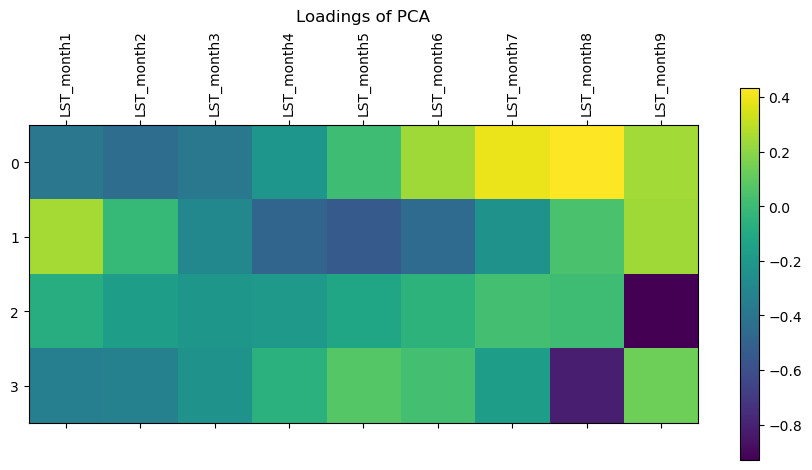

In [48]:
# PCA 
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X)

# plot the explained variance ratio
plt.figure()
plt.bar(range(4), pca.explained_variance_ratio_)
plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.title('Explained variance ratio of PCA')
plt.show()

# loadings
loadings = pca.components_
plt.figure()
plt.matshow(loadings)
plt.xticks(range(len(columns_LST)), columns_LST, rotation=90)
plt.yticks(range(4), range(4))
plt.colorbar()
plt.title('Loadings of PCA')
plt.show()


In [49]:
# only use the first two principal components
X_pca = X_pca[:, :2]


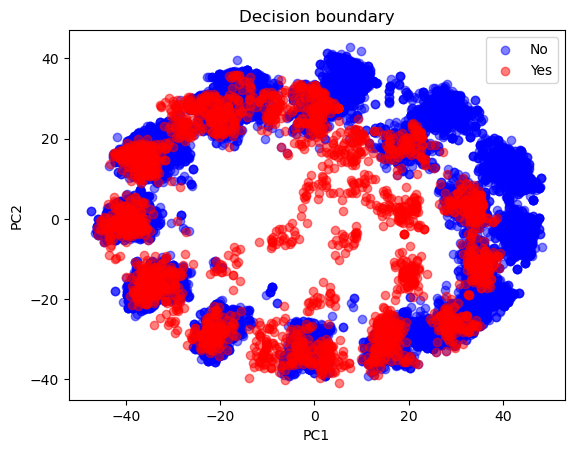

In [52]:
# plot the decision boundary
plt.figure()
plt.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], c='b', label='No', alpha=0.5)
plt.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], c='r', label='Yes', alpha=0.5)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Decision boundary')
plt.legend()
plt.show()

# COMMENT: I don't see a clear decision boundary


## Logistic regression

In [53]:
# divide the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=0)


In [54]:
# build a logistic regression model
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)

# test the model
y_pred = model.predict(X_test)

# confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

# accuracy
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

# NOTE, the model is predicting all as 0, which is not good


[[4066    0]
 [ 595    0]]
0.8723449903454195
